In [1]:
import sys, os
sys.path.append("/opt/anaconda3/lib/python3.8/site-packages")

In [54]:
import numpy as np
import pandas as pd
import cv2 as cv
from skimage.feature import hog
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import pickle

from time import time
from tqdm import tqdm
from multiprocessing import Pool
import json

# Utility functions

In [3]:
def img_resize(img, size):
    return cv.resize(img, size)


def get_img(img_path):
    img = cv.imread(img_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    return img

# ref : https://docs.opencv.org/4.x/dd/d3b/tutorial_py_svm_opencv.html
def deskew(img):
    m = cv.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    img = cv.warpAffine(img,M,(SZ, SZ),flags=affine_flags)
    return img

### check datas

numpy.ndarray

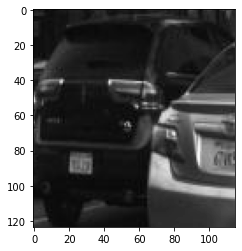

In [4]:
DATA_DIR = "path"
annotation_file = "_annotations.csv"

annotation = pd.read_csv(DATA_DIR + "/" + annotation_file)
for index, row in annotation.iterrows():
    file_name, w, h, c, xmin, ymin, xmax, ymax = row
    
    img = get_img(DATA_DIR + "/" + file_name)
    plt.imshow(img[ymin:ymax, xmin:xmax], cmap="gray")
    
    if index == 6:
        break

type(img)

# 1. HOG + SVM (Vanila ver.)

## Loading Data
Dataset used : Udacity Self Driving Car Dataset (https://public.roboflow.com/object-detection/self-driving-car) (small set with COCO JSON format)

Split data to train set(else) / test set(image_id : 0 ~ 999)

In [5]:
DATA_DIR = "path"


In [32]:
# codes for data exploration(checking the annotations etc.)
annotation_path = DATA_DIR + "/" + "_annotations.coco.json"
with open(annotation_path, "r") as json_file:
    annotations = json.load(json_file)
    
annotations.keys()

dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])

we consider objects labeled as "car" or "truck" as vehicle

(with id = 2, 11)

In [7]:
print(json.dumps(annotations["categories"], indent=4))

[
    {
        "id": 0,
        "name": "obstacles",
        "supercategory": "none"
    },
    {
        "id": 1,
        "name": "biker",
        "supercategory": "obstacles"
    },
    {
        "id": 2,
        "name": "car",
        "supercategory": "obstacles"
    },
    {
        "id": 3,
        "name": "pedestrian",
        "supercategory": "obstacles"
    },
    {
        "id": 4,
        "name": "trafficLight",
        "supercategory": "obstacles"
    },
    {
        "id": 5,
        "name": "trafficLight-Green",
        "supercategory": "obstacles"
    },
    {
        "id": 6,
        "name": "trafficLight-GreenLeft",
        "supercategory": "obstacles"
    },
    {
        "id": 7,
        "name": "trafficLight-Red",
        "supercategory": "obstacles"
    },
    {
        "id": 8,
        "name": "trafficLight-RedLeft",
        "supercategory": "obstacles"
    },
    {
        "id": 9,
        "name": "trafficLight-Yellow",
        "supercategory": "obstacles"
    },

In [6]:
CROPPED_SIZE = (64, 64)
VEHICLE_ID_SET = {2, 11}

def load_data(annotations : dict, num_of_data=None):
    """
    Args:
        annotations : annotation file as a json format (dict)
        num_of_data : maximum_size of train / test set (option for debugging)
    Returns:
        X_train : cropped image of the object    (train set)
        y_train : label (1 : vehicel, 0 : non-vehicle)
        X_test : cropped image of the object    (test set)
        y_test : label (1 : vehicel, 0 : non-vehicle)
    """
    s = time()
    
    X_train, X_test, y_train, y_test = [], [], [], []
        
    for annotation in tqdm(annotations["annotations"]):
        file_name = annotations["images"][annotation["image_id"]]["file_name"]
        img_path = DATA_DIR + "/" + file_name
        
        img = get_img(img_path)
        top_left_x, top_left_y, w, h = map(int, annotation["bbox"])
        cropped_img = cv.resize(img[top_left_y:top_left_y + h, top_left_x:top_left_x + w], CROPPED_SIZE)
        
        if annotation["category_id"] in VEHICLE_ID_SET:
            label = 1
        else:
            label = 0
            
        if 0 <= annotation["image_id"] < 1000:
            X_test.append(cropped_img)
            y_test.append(label)
        else:
            X_train.append(cropped_img)
            y_train.append(label)
        
        if num_of_data:
            if len(X_train) >= num_of_data or len(X_test) >= num_of_data:
                print(f"{num_of_data} datas retrieved!!! stop loading!!!")
                break
    
    print(f"data loading done in {round(time() - s)} sec")
    
    return X_train, X_test, y_train, y_test


In [9]:
# X_train, X_test, y_train, y_test = load_data(annotations)

1


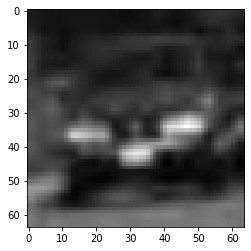

In [10]:
#check if the dataset is loaded properly
plt.imshow(X_test[0], cmap="gray")
print(y_test[0])

In [14]:
# save dataset
data_set_basic = {
    "X_train" : X_train,
    "X_test" : X_test,
    "y_train" : y_train,
    "y_test" : y_test,
}

# with open("pickle_data/data_set_basic.pickle", "wb") as f:
#     pickle.dump(data_set_basic, f)

In [7]:
# load dataset
s = time()
with open("pickle_data/data_set_basic.pickle", "rb") as f:
    data_set_basic = pickle.load(f)
print(f"loaded data in {time() - s} sec")

X_train = np.array(data_set_basic["X_train"])
X_test = np.array(data_set_basic["X_test"])
y_train = np.array(data_set_basic["y_train"])
y_test = np.array(data_set_basic["y_test"])


# vectorized ver.
pos_indices = np.argwhere(y_train == 1).squeeze()
neg_indices = np.argwhere(y_train == 0).squeeze()

X_train_pos = X_train[pos_indices]
X_train_neg = X_train[neg_indices]

loaded data in 0.9998271465301514 sec


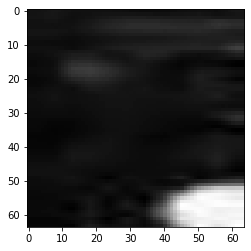

In [8]:
plt.imshow(X_train_pos[100], cmap="gray")
plt.imshow(X_train_neg[0], cmap="gray")

## Generate Data set (of cropped images)
- for training, I've compressed the dataset and generated some negative datas

In [30]:
print(f"""
number of positive training samples : {len(X_train_pos)}
number of negative training samples : {len(X_train_neg)}

number of test samples              : {len(X_test)} 
""")


number of positive training samples : 130564
number of negative training samples : 57638

number of test samples              : 6337 



## Get test set (of full images)

In [33]:
X_test_img = []
#(img, img_id)

for img_id in tqdm(range(1000)):
    file_name = annotations["images"][img_id]["file_name"]
    img_path = DATA_DIR + "/" + file_name
    img = get_img(img_path)
    X_test_img.append((img, img_id))

100%|██████████████████████████████████████| 1000/1000 [00:04<00:00, 227.33it/s]


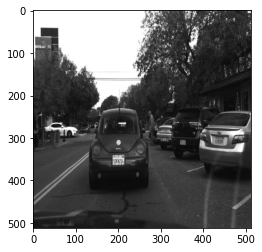

In [34]:
plt.imshow(X_test_img[2][0], cmap="gray")

In [32]:
X_test_img[2][1]

2

## Extract HOG features
use openCV instead of scikit-learn Since openCV is much faster

In [11]:
# help(cv.HOGDescriptor)

In [35]:
class HogExtractor:
    def __init__(self, hog_params):
        """
        Args:
            hog_params : parameters for HOG
        """
        self.hog_params = hog_params
        self.HOGDescriptor = cv.HOGDescriptor(
            hog_params["winSize"], 
            hog_params["blockSize"],
            hog_params["blockStride"], 
            hog_params["cellSize"], 
            hog_params["nbins"], 
            hog_params["derivAperture"], 
            hog_params["winSigma"], 
            hog_params["histogramNormType"], 
            hog_params["L2HysThreshold"], 
            hog_params["gammaCorrection"], 
            hog_params["nlevels"], 
            hog_params["signedGradients"], 
        )
        
    
    def img2HOG(self ,img):
        """
        Args:
            img : input image

        Retruns:
            1D hog feature vector of input img
        """
        hog_features = self.HOGDescriptor.compute(img)

        return hog_features
    
    def visualize_hog(self, img):
        """
        Args:
            img : input image

        Retruns:
            Image of HOG representation of the input image
        """
        feature_vec, hog_img = hog(img,
                                   orientations=self.hog_params["nbins"], 
                                   pixels_per_cell=self.hog_params["cellSize"],
                                   cells_per_block=self.hog_params["blockSize"],
                                   feature_vector=True,
                                   visualize=True,
                                   multichannel=False
                                  )
        return hog_img
    
    def img2HOG_sklearn(self, img):
        """
        Args:
            img : input image

        Retruns:
            1D hog feature vector of input img computed with scikit-learn
        """
        feature_vec, hog_img = hog(img,
                                   orientations=self.hog_params["nbins"], 
                                   pixels_per_cell=self.hog_params["cellSize"],
                                   cells_per_block=self.hog_params["blockSize"],
                                   feature_vector=True,
                                   visualize=True,
                                   multichannel=False
                                  )
        return feature_vec

In [36]:
hog_params = {
    "winSize" : (64, 64),
    "blockSize" : (2, 2),
    "blockStride" : None,
    "cellSize" : (8, 8),
    "nbins" : 20,
    "derivAperture" : 1,
    "winSigma" : -1,
    "histogramNormType" : 0,
    "L2HysThreshold" : 0.2,
    "gammaCorrection" : 1,
    "nlevels" : 64,
    "signedGradients" : False,
}

HOG = HogExtractor(hog_params)

Check if the HOG features are extracted properly

(for visualization, use sikit-learn Since they offer a method for visualization. except this step, use opencv instead)

1 0


Text(0.5, 1.0, 'Non-Vehicle HOG representation')

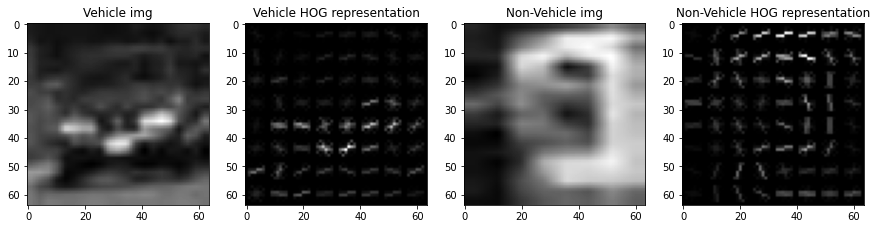

In [37]:
pos_idx, neg_idx = 0, 1000
print(y_test[pos_idx], y_test[neg_idx])

vehicle_img_smaple = X_test[pos_idx]
non_vehicle_img_smaple = X_test[neg_idx]

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize=(15,5))

ax1.imshow(vehicle_img_smaple, cmap="gray")
ax1.set_title("Vehicle img")
ax2.imshow(HOG.visualize_hog(vehicle_img_smaple), cmap="gray")
ax2.set_title("Vehicle HOG representation")
ax3.imshow(non_vehicle_img_smaple, cmap="gray")
ax3.set_title("Non-Vehicle img")
ax4.imshow(HOG.visualize_hog(non_vehicle_img_smaple), cmap="gray")
ax4.set_title("Non-Vehicle HOG representation")

Check if the HOG features that we used for visualization is compatable with the ones we are going to use to train our classifier(SVM)

In [18]:
# print(HOG.img2HOG(vehicle_img_smaple)) -> 현재는 커널 죽음
print(HOG.img2HOG_sklearn(vehicle_img_smaple))

[0.25730692 0.02357564 0.01808169 ... 0.02919156 0.01391841 0.        ]


## Preprocessing

Since we are going to use the data with SVM, which is quite sensitive with the scale of data, I used StandardScaler from sklearn

this preprocessing step consist of two steps,

1. extract the HOG faetures of the image
2. scale the datas for SVM


In [38]:
class Preprocessor:
    def __init__(self, HogExtractor, scaler):
        """
            Args:
                HogExtractor: HogExtractor object
                scaler : scaler object
        """
        self.HogExtractor = HogExtractor
        self.scaler = scaler
        
        
    def preprocess(self, img_dataset, test=False, verbose=True):
        """
            Args:
                img_dataset: array of cropped img datas
                test: True when preprocessing test set
            Returns:
                Array of HOG feature vectors which is scaled.
        """
        scaled_HOG_vectors = []

        # Extract HOG features
        if verbose:
            _iterator = tqdm(img_dataset)
        else:
            _iterator = img_dataset
        
        for img in _iterator:
            scaled_HOG_vectors.append(self.HogExtractor.img2HOG_sklearn(img))

        scaled_HOG_vectors = np.array(scaled_HOG_vectors)
        
        # train(fit) the scaler
        if not test:
            if verbose:
                print(" fitting the scaler...")
            self.scaler.fit(scaled_HOG_vectors)
        else:
            pass
        
        if verbose:
            print(" transforming to HOG vectors...")
        scaled_HOG_vectors = self.scaler.transform(scaled_HOG_vectors)

        return scaled_HOG_vectors

## Train SVM Classifier

I used LinearSVC Since,
> Similar to SVC with parameter kernel=’linear’, but implemented in terms of liblinear rather than libsvm, so it has more flexibility in the choice of penalties and loss functions and should scale better to large numbers of samples. 
>
>-- <cite>sklearn.svm.LinearSVC documentation</cite>

In [20]:
#Preprocessing
scaler = StandardScaler()
preprocessor = Preprocessor(HOG, scaler)
HOG_train = preprocessor.preprocess(X_train, test=False)
HOG_test = preprocessor.preprocess(X_test, test=True)


100%|███████████████████████████████████| 188202/188202 [48:44<00:00, 64.36it/s]


 fitting the scaler...
 transforming to HOG vectors...


100%|███████████████████████████████████████| 6337/6337 [01:34<00:00, 66.97it/s]


 transforming to HOG vectors...


In [46]:
#train preprocessor 
#(HOG loading 해서 쓴 경우 좀 compatable 하지 않은 부분이 있긴함. 추후에 수정)

#작은 데이터 셋에 대해 sclater fitting
scaler = StandardScaler()
preprocessor = Preprocessor(HOG, scaler)
preprocessor.preprocess(X_train[baseline_indices], test=False)


100%|█████████████████████████████████████| 20000/20000 [05:15<00:00, 63.41it/s]


 fitting the scaler...
 transforming to HOG vectors...


array([[-0.63824212, -0.54994873, -0.4380436 , ..., -0.54893768,
        -0.4586234 , -0.38809017],
       [ 0.57684801, -0.54994873, -0.65367053, ..., -0.10066787,
        -0.4586234 , -0.38809017],
       [ 0.90675187,  1.09460874, -0.65367053, ..., -0.54893768,
        -0.4586234 , -0.38809017],
       ...,
       [-0.20827369, -0.54994873, -0.65367053, ...,  1.61830415,
         0.40455712, -0.38809017],
       [-1.1548918 , -0.54994873, -0.65367053, ..., -0.09941904,
        -0.4586234 , -0.38809017],
       [ 0.09082344, -0.08167879, -0.23772246, ..., -0.22148555,
        -0.17636807, -0.38809017]])

### Save HOG features as pickle file

In [21]:
# HOG_baisc = {
#     "X_train": HOG_train,
#     "X_test": HOG_test,
# }

# # save HOG 
# with open("pickle_data/HOG_baisc.pickle", "wb") as f:
#     pickle.dump(HOG_baisc, f)

In [39]:
# load HOG
s = time()
with open("pickle_data/HOG_baisc.pickle", "rb") as f:
    HOG_baisc = pickle.load(f)
print(f"loaded HOG data in {time() - s}sec")

HOG_train = np.array(HOG_baisc["X_train"])
HOG_test = np.array(HOG_baisc["X_test"])

HOG_train_pos = HOG_train[pos_indices]
HOG_train_neg = HOG_train[neg_indices]

loaded HOG data in 6.612183094024658sec


In [ ]:
HOG_train_pos[0:10].shape

### Baseline
- just use each(pos, neg) 10,000 samples

In [43]:
s = time()
baseline_indices = np.concatenate((pos_indices[0:10000], neg_indices[0:10000]), axis = 0)
HOG_train_baseline = HOG_train[baseline_indices]
y_train_baseline = y_train[baseline_indices]
print(f"time : {time() - s}sec")
# 처음 돌릴때는 10초 정도 걸리는 듯

time : 0.6220006942749023sec


In [44]:
C = 1 #regularization parameter
SVC = svm.LinearSVC(C=C)

#train classifier
print("training SVC...")
s = time()
SVC.fit(HOG_train_baseline, y_train_baseline)
print(f"training time : {time() - s}")


training SVC...
training time : 50.077739000320435


/Users/dongsubshin/Desktop/prodigy-sub/Hands-On-ML/env/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [45]:
print("train set acc : {:.2f}".format(SVC.score(HOG_train_baseline, y_train_baseline)))
print("test set acc  : {:.2f}".format(SVC.score(HOG_test, y_test)))

train set acc : 1.00
test set acc  : 0.87


### Higher regularization
- C = 1000

In [67]:
C = 1000
SVC = svm.LinearSVC(C=C)

#train classifier
print("training SVC...")
s = time()
SVC.fit(HOG_train_baseline, y_train_baseline)
print(f"training time : {time() - s}")

print("train set acc : {:.2f}".format(SVC.score(HOG_train_baseline, y_train_baseline)))
print("test set acc  : {:.2f}".format(SVC.score(HOG_test, y_test)))

training SVC...
training time : 51.08743715286255
train set acc : 1.00
test set acc  : 0.87


/Users/dongsubshin/Desktop/prodigy-sub/Hands-On-ML/env/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### More iteration
- max_iter = 10,000

In [68]:
C = 1 #regularization parameter
max_iter = 10000
SVC = svm.LinearSVC(C=C, max_iter=max_iter)

#train classifier
print("training SVC...")
s = time()
SVC.fit(HOG_train_baseline, y_train_baseline)
print(f"training time : {time() - s}")

print("train set acc : {:.2f}".format(SVC.score(HOG_train_baseline, y_train_baseline)))
print("test set acc  : {:.2f}".format(SVC.score(HOG_test, y_test)))

training SVC...


/Users/dongsubshin/Desktop/prodigy-sub/Hands-On-ML/env/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


training time : 329.1601321697235
train set acc : 1.00
test set acc  : 0.87


## Sliding window

In [115]:
# ref : https://github.com/nrsyed/svm-vehicle-detector

def sliding_window(image_size, initial_size, x_overlap, y_step, scale, y_range):
    
    # window contains the boundary box of each window
    windows = []
    W, H = image_size
    
    for y in range(int(y_range[0] * H), int(y_range[1] * H), int(y_step * H)):
        
        win_width = int(initial_size[0] + (scale * (y - (y_range[0] * H))))
        win_height = int(initial_size[1] + (scale * (y - (y_range[0] * H))))
        
        if y + win_height > int(y_range[1] * H) or win_width > W:
            break
            
        x_step = int((1 - x_overlap) * win_width)
        
        for x in range(0, W, x_step):
            windows.append((x, y, x + win_width, y + win_height))

    return windows

# def sliding_window_with_xrange(image_size, initial_size, x_overlap, y_step, scale, y_range):
    
#     # window contains the boundary box of each window
#     windows = []
#     W, H = image_size
    
#     for y in range(int(y_range[0] * H), int(y_range[1] * H), int(y_step * H)):
        
#         win_width = int(initial_size[0] + (scale * (y - (y_range[0] * h))))
#         win_height = int(initial_size[1] + (scale * (y - (y_range[0] * h))))
        
#         if y + win_height > int(y_range[1] * h) or win_width > W:
#             break
            
#         x_step = int((1 - x_overlap) * win_width)
        
#         for x in range(0, W, x_step):
#             windows.append((x, y, x + win_width, y + win_height))

#     return windows



In [85]:
# sliding_window(image_size=(512, 512),
#                             initial_size=(90,90),
#                             x_overlap=0.7,
#                             y_step=0.01,
#                             scale=1.3,
#                             y_range=[0,1])

## Object Detector
- input : full image
- detect vehicles in the full image

In [28]:
a = [(1,2,np.array([1,2,3,4])),(1,2,np.array([0,0,0,0]))]
np_a = np.array(a, dtype=object)
np_a[:,2]
# (score, 0, window)

array([array([1, 2, 3, 4]), array([0, 0, 0, 0])], dtype=object)

In [48]:
class ObjectDetector:
    def __init__(self, classifier, preprocessor):
        self.classifier = classifier
        self.preprocessor = preprocessor
        self.windows = None
    
    def set_windows(self, image_size, initial_size, x_overlap, y_step, scale, y_range):
        self.windows = sliding_window(image_size, initial_size, x_overlap, y_step, scale, y_range)
        print("window setting complete!")
    
    # ver.1 여기에 window 랑 img id 같이 알 수 있도록 변경
    # ver.2 아예 y_score랑 y_true 같이 나오도록 코드 짜는게 효율적일듯
    def _detect_img(self, image, img_id, threshold=0.5):
        # bbox(window) : x(x1), y(y1), x+w(x2), y+h(y2)
        
        y_pos = [] #(score, y_test, window)
        y_neg = []
        
        if not self.windows:
            raise Exception('you should set windows first!')
        
        for window in self.windows:
            x1, y1, x2, y2 = window
            cropped_img = cv.resize(image[y1:y2, x1:x2], CROPPED_SIZE)
            feature_vec = self.preprocessor.preprocess([cropped_img], test=True, verbose=False)
            score = self.classifier.decision_function(feature_vec)
            
            iou = self._get_test_IOU(window, img_id)
            if iou > threshold:
                y_pos.append((score, 1, window))
            else:
                y_neg.append((score, 0, window))
            
        #nms
        y_pos.sort(key=lambda x:x[0])

        y_pos = np.array(y_pos, dtype=object)
        y_pos = self._nms(y_pos)
        y_neg = np.array(y_neg, dtype=object)
        
        if y_pos.size == 0:
            y_total = y_neg
        elif not y_neg:
            y_total = y_pos
        else:
            y_total = np.concatenate((y_pos, y_neg), axis=None)

        y_score, y_test = list(y_total[:,0]), list(y_total[:,1])
        
        return y_score, y_test
    
    def detect_dataset(self, test_dataset, threshold=0.5):
        y_score_list, y_test_list = [], []
        
        print("detecting start ...")
        for img, img_id in tqdm(test_dataset):
            y_score, y_test = self._detect_img(img, img_id, threshold)
            y_score_list += y_score
            y_test_list += y_test
        
        return y_score_list, y_test_list
    
    def _cal_IoU(self, box1, box2):
        # ref: https://minimin2.tistory.com/144
        # box = (x1, y1, x2, y2)
        box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
        box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

        x1 = max(box1[0], box2[0])
        y1 = max(box1[1], box2[1])
        x2 = min(box1[2], box2[2])
        y2 = min(box1[3], box2[3])

        w = max(0, x2 - x1 + 1)
        h = max(0, y2 - y1 + 1)

        inter = w * h
        iou = inter / (box1_area + box2_area - inter)
        return iou

    def _get_test_IOU(self, window, img_id):
        #Since the classifier is supposed to detect 1 object in a box, we take the maximum IOU
        max_iou = 0
        for box in bbox[img_id]:
            max_iou = max(max_iou, self._cal_IoU(window, box))

        return max_iou
    
    # ref : https://github.com/BichenWuUCB/squeezeDet/blob
    # 너무 느리면 vectorized 구현으로 바꿀 수 있는 부분일 듯
    def _nms(self, y_pos, nms_threshold_iou=0.5): #(score, y_test, window)
        keep = [True] * len(y_pos)
        
        for i in range(len(y_pos)):
            if not keep[i]:
                continue
                
            for j in range(i, len(y_pos)):
                box_i, box_j = y_pos[i][2], y_pos[j][2]
                if self._cal_IoU(box_i, box_j) > nms_threshold_iou:
                    keep[j] = False
        
        return y_pos[keep]
    

## Evaluation
- ROC, precision-recall, average precision

In [49]:
object_detector = ObjectDetector(SVC, preprocessor)

In [157]:
X_test_img[0][0].shape

(512, 512)

In [158]:
img = X_test_img[0][0]
vec, hogimg = hog(img,
                                   orientations=hog_params["nbins"], 
                                   pixels_per_cell=hog_params["cellSize"],
                                   cells_per_block=hog_params["blockSize"],
                                   feature_vector=True,
                                   visualize=True,
                                   multichannel=False
                                  )
vec

array([0.15489904, 0.02355529, 0.0079514 , ..., 0.13161217, 0.        ,
       0.        ])

In [125]:
# self, image_size, initial_size, x_overlap, y_step, scale, y_range
object_detector.set_windows(image_size=(512, 512),
                            initial_size=(20,20),
                            x_overlap=0.7,
                            y_step=0.01,
                            scale=1.3,
                            y_range=[0.45,0.9])
# object_detector.windows
# y_score_list, y_test_list = object_detector.detect_dataset(X_test_img)

window setting complete!


In [56]:
# base_line = {
#     "y_score_list": y_score_list,
#     "y_test_list": y_test_list,
#     "svm" : SVC,
# }

# # save base_line 
# with open("pickle_data/base_line.pickle", "wb") as f:
#     pickle.dump(base_line, f)

In [51]:
# get bbox of each img_id for test set to calculate IOU
from collections import defaultdict
bbox = defaultdict(list)

img_id = 0
i = 0

s = time()
while True:

    annotation = annotations["annotations"][i]
    
    if annotation["image_id"] > 1000:
        break
    if annotation["category_id"] in VEHICLE_ID_SET:
        top_left_x, top_left_y, w, h = map(int, annotation["bbox"])
        x1, y1, x2, y2 = top_left_x, top_left_y, top_left_x + w, top_left_y + h

        bbox[annotation["image_id"]].append([x1, y1, x2, y2])
    i += 1

print(f"done in {time() - s}sec")

done in 0.29231905937194824sec


In [124]:
def evaluate_model(y_test, y_scores):
    
    # 필요한 점수들 계산 코드 이쪽에
    fpr, tpr, thresholds = roc_curve(y_test, y_scores, pos_label=1)
    roc_auc = auc(fpr, tpr)
    precision, recall, thresholds = precision_recall_curve(y_test, y_scores, pos_label=1)
    
    # plot
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))

    ax1.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=2,
        label="ROC curve (area = %0.2f)" % roc_auc,
    )
    ax1.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel("FP Rate")
    ax1.set_ylabel("TP Rate")
    ax1.set_title("ROC curve")
    ax1.legend(loc="lower right")
    
    ax2.plot(recall, precision)
    ax2.set_xlabel("Recall")
    ax2.set_ylabel("Precision")
    ax2.set_title("Precision-Recall curve")
    
    print(f"Average Precision : {average_precision_score(y_test, y_scores)}")
    
    

/Users/dongsubshin/Desktop/prodigy-sub/Hands-On-ML/env/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/dongsubshin/Desktop/prodigy-sub/Hands-On-ML/env/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Average Precision : nan


/Users/dongsubshin/Desktop/prodigy-sub/Hands-On-ML/env/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


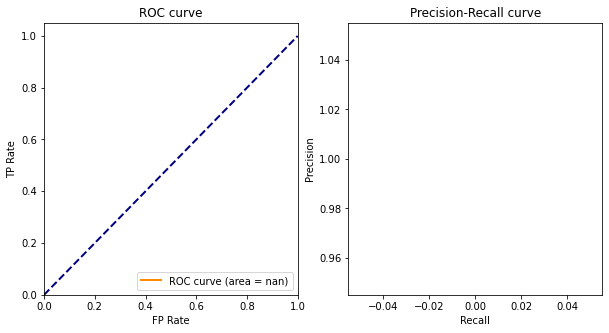

In [68]:
evaluate_model(y_test_list, y_score_list)

# Loading Datasets with TF format
- 어떤 방식으로 data를 load하는 것이 가장 속도면에서 빠른지 비교하기 위해 다양한 방법으로 구현을 시도함.

numpy.ndarray

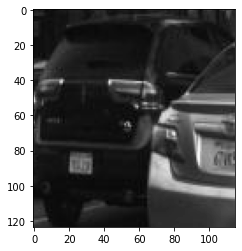

In [6]:
# dummy codes for checking the data
DATA_DIR = "path"
annotation_file = "_annotations.csv"

annotation = pd.read_csv(DATA_DIR + "/" + annotation_file)
for index, row in annotation.iterrows():
    file_name, w, h, c, xmin, ymin, xmax, ymax = row
    
    img = get_img(DATA_DIR + "/" + file_name)
    plt.imshow(img[ymin:ymax, xmin:xmax], cmap="gray")
    
    if index == 6:
        break

type(img)

In [5]:
CROPPED_SIZE = (64, 64)

#small 기준 : 584s
def load_data(DATA_DIR, annotation_file):
    """
    Args:
        DATA_DIR : dataset directory path
        annotation_file : name for the annotaion file with filename, oordinates of the objects and label
    Returns:
        X : croped image of the object
        y : label (vehicel, non-vehicle)
    """
    s = time()
    
    X_list = []
    y_list = []
    
    annotation_df = pd.read_csv(DATA_DIR + "/" + annotation_file)
    
    #looping 가능하면 vectorization으로 바꾸자(dataset 하나에 대해서 돌리는데도 10분정도 걸림)
    for idx , row in tqdm(annotation_df.iterrows()):
        file_name, w, h, class_, xmin, ymin, xmax, ymax = row
        
        img_path = DATA_DIR + "/" + file_name
        img = get_img(img_path)
        
        cropped_img = cv.resize(img[ymin:ymax, xmin:xmax], CROPPED_SIZE)
        
        if class_ == "car":
            label = 1
        else:
            label = 0
        
        X_list.append(cropped_img)
        y_list.append(label)
        
        X, y = np.array(X_list), np.array(y_list)
    
    print(f"data loading done in {round(time() - s)} sec")
    
    return X, y

# ref: https://python.plainenglish.io/pandas-how-you-can-speed-up-50x-using-vectorized-operations-d6e829317f30
# referecne for boosting the speed of data preprocessing

def get_cropped_img(DATA_DIR, file_name, xmin, ymin, xmax, ymax):
    img_path = DATA_DIR + "/" + file_name
    img = get_img(img_path)

    cropped_img = cv.resize(img[ymin:ymax, xmin:xmax], CROPPED_SIZE)
    
    return cropped_img


def get_label(class_):
    
    if class_ == "car":
        label = 1
    else:
        label = 0
    
    return label
    
#small 기준 : 534s
def load_data_apply(DATA_DIR, annotation_file):
    """
    Args:
        DATA_DIR : dataset directory path
        annotation_file : name for the annotaion file with filename, oordinates of the objects and label
    Returns:
        X : croped image of the object
        y : label (vehicel, non-vehicle)
    """
    s = time()
    
    annotation_df = pd.read_csv(DATA_DIR + "/" + annotation_file)
    
    X = annotation_df.apply(lambda df: get_cropped_img(DATA_DIR,
                                                       df["filename"],
                                                       df["xmin"],
                                                       df["ymin"],
                                                       df["xmax"],
                                                       df["ymax"]
                                                     ), axis=1)
    
    y = annotation_df.apply(lambda df: get_label(df["class"]), axis=1)
    
    X, y = np.array(X), np.array(y)
    
    print(f"data loading done in {round(time() - s)} sec")
    
    return X, y

#small 기준 : 565s
def load_data_list_comprehension(DATA_DIR, annotation_file):
    """
    Args:
        DATA_DIR : dataset directory path
        annotation_file : name for the annotaion file with filename, oordinates of the objects and label
    Returns:
        X : croped image of the object
        y : label (vehicel, non-vehicle)
    """
    s = time()
    
    annotation_df = pd.read_csv(DATA_DIR + "/" + annotation_file)
    annotation_list = list(annotation_df.iterrows())
    
    X = [get_cropped_img(DATA_DIR, el[1]["filename"], el[1]["xmin"], el[1]["ymin"], el[1]["xmax"], el[1]["ymax"]) for el in annotation_list]
    y = [get_label(el[1]["class"]) for el in annotation_list]
    
    
    X, y = np.array(X), np.array(y)
    
    print(f"data loading done in {round(time() - s)} sec")
    
    return X, y

# multi processing 을 하려면 ipython이 아닌 환경에서 돌리거나, 따로 함수를 작성한 모듈을 import해서 해야하는 듯
# ref : https://stackoverflow.com/questions/41385708/multiprocessing-example-giving-attributeerror/42383397
def get_cropped_img_multi_core_small(el):
    file_name, xmin, ymin, xmax, ymax = el[1]["filename"], el[1]["xmin"], el[1]["ymin"], el[1]["xmax"], el[1]["ymax"]

    img_path = DATA_DIR_SMALL + "/" + file_name
    img = get_img(img_path)

    cropped_img = cv.resize(img[ymin:ymax, xmin:xmax], CROPPED_SIZE)

    return cropped_img

def load_data_multi_processing(DATA_DIR, annotation_file):
    """
    Args:
        DATA_DIR : dataset directory path
        annotation_file : name for the annotaion file with filename, oordinates of the objects and label
    Returns:
        X : croped image of the object
        y : label (vehicel, non-vehicle)
    """
    s = time()
    
    annotation_df = pd.read_csv(DATA_DIR + "/" + annotation_file)
    annotation_list = list(annotation_df.iterrows())
    
    pool = Pool(4)
    
    X = pool.map(get_cropped_img_multi_core_small, annotation_list)
    y = [get_label(el[1]["class"]) for el in annotation_list]
    
    
    X, y = np.array(X), np.array(y)
    
    print(f"data loading done in {round(time() - s)} sec")
    
    return X, y
